In [1]:
# numpy and pandas for data manipulation
import sys
import os
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import cPickle as pickle

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/'
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/collaborative-optimizer'
root_data = ROOT + '/data'

sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.execution_environment import ExecutionEnvironment
from experiment_graph.executor import CollaborativeExecutor
from experiment_graph.workload import Workload


DATABASE_PATH = root_data + '/experiment_graphs/home-credit-default-risk/materialized-no-groupby'
N_ESTIMATOR = 100
from experiment_graph.optimizations.Reuse import HelixReuse
from experiment_graph.optimizations.Reuse import LinearTimeReuse
reuse_type=HelixReuse.NAME

def plot_graph(graph, figsize=(20,10),prog='dot', vertex_labels=True, edge_labels = True):
    from networkx.drawing.nx_agraph import graphviz_layout
    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(1, 1, 1)
    pos = graphviz_layout(graph, prog=prog, args='')
    #pos = nx.drawing.layout.spring_layout(graph)
    jet = plt.get_cmap('gist_rainbow')
    nx.draw_networkx(
        graph,
        cmap=jet,
        # vmin=0,
        # vmax=len(unique_types),
        node_shape='s',
        pos=pos,
        with_labels=False,
        ax=ax)
    if vertex_labels:
        labels = {n_id:'{},{}'.format(n_id[:10],node.values()) for n_id, node in graph.nodes(data=True)}
        nx.draw_networkx_labels(graph,pos=pos,labels=labels)
    if edge_labels:
        nx.draw_networkx_edge_labels(
            graph,
            pos=pos,
            edge_labels={(u, v): d for u, v, d in graph.edges(data=True)})

In [2]:
def helix_reuse(terminal, ee):
    return HelixReuse().run(terminal, ee.workload_dag, ee.experiment_graph, verbose = 0)

def linear_reuse(terminal, ee):
    return LinearTimeReuse().run(terminal, ee.workload_dag, ee.experiment_graph, verbose = 0)

In [3]:
ee = ExecutionEnvironment(reuse_type=reuse_type) 
executor = CollaborativeExecutor(ee)

In [4]:
class BaseWorkload(Workload):
    def run(self, execution_environment, root_data, verbose):
        # Load Data
        train = ee.load(root_data + '/openml/task_id=31/datasets/train.csv')
        test = ee.load(root_data + '/openml/task_id=31/datasets/test.csv')

        test_labels = test['class']
        test = test.drop('class')

        train_labels = train['class']
        train = train.drop(columns=['class'])

        from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(train)
        train = scaler.transform(train)
        #train.data()
        test = scaler.transform(test)

        # Random Forest 1 (n_estimator = 10)
        from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
        random_forest10 = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
        random_forest10.fit(train, train_labels)

        # Execute
        #random_forest10.trained_node.data()

        print 'score: {}'.format(random_forest10.score(test, test_labels).data(verbose=verbose))
        return True
base_workload = BaseWorkload()
executor.end_to_end_run(workload=base_workload, root_data=root_data, verbose=1)

creating a new root node
creating a new root node


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


executing 18 steps to compute vertex AD4CB332A23AF19C1150A43876F369FD
score: {'accuracy': 0.79000000000000004}


True

In [5]:
class ReuseMinMaxWorkload(Workload):
     def run(self, execution_environment, root_data, verbose):
        # Load Data
        train = ee.load(root_data + '/openml/task_id=31/train.csv')
        test = ee.load(root_data + '/openml/task_id=31/test.csv')

        test_labels = test['class']
        test = test.drop('class')

        train_labels = train['class']
        train = train.drop(columns=['class'])

        from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)
        return train.id
min_max_reuse = ReuseMinMaxWorkload()
terminal_vertex = executor.run_workload(workload=min_max_reuse, root_data=root_data, verbose = 1)

In [6]:
mat_helix, compute_helix,_ = helix_reuse(terminal_vertex, executor.execution_environment)
mat_linear, compute_linear,_ = linear_reuse(terminal_vertex, executor.execution_environment)
print(mat_helix,mat_linear)
assert mat_helix == mat_linear
assert compute_linear == compute_helix
executor.cleanup()

(set(['C2B2A08B3D0EFA08C2A06B7187FF500B']), set(['C2B2A08B3D0EFA08C2A06B7187FF500B']))


True

In [7]:
class ReuseAfterMinMaxWorkload(Workload):
     def run(self, execution_environment, root_data, verbose):
        # Load Data
        train = ee.load(root_data + '/openml/task_id=31/train.csv')
        test = ee.load(root_data + '/openml/task_id=31/test.csv')

        test_labels = test['class']
        test = test.drop('class')

        train_labels = train['class']
        train = train.drop(columns=['class'])

        from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)
        train = train.mean()
        return train.id
after_min_max_reuse = ReuseAfterMinMaxWorkload()
terminal_vertex = executor.run_workload(workload=after_min_max_reuse, root_data=root_data, verbose = 1)
terminal_vertex

'10FADDADCD322037D9D3DCC635A54C14'

In [8]:
mat_helix, compute_helix,_ = helix_reuse(terminal_vertex, executor.execution_environment)
mat_linear, compute_linear,_ = linear_reuse(terminal_vertex, executor.execution_environment)
print(mat_helix,mat_linear)
assert mat_helix == mat_linear
assert compute_linear == compute_helix
executor.cleanup()

(set(['C2B2A08B3D0EFA08C2A06B7187FF500B']), set(['C2B2A08B3D0EFA08C2A06B7187FF500B']))


True

In [9]:
class ReuseFullWorkload(Workload):
    def run(self, execution_environment, root_data, verbose):
        # Load Data
        train = ee.load(root_data + '/openml/task_id=31/train.csv')
        test = ee.load(root_data + '/openml/task_id=31/test.csv')

        test_labels = test['class']
        test = test.drop('class')
        #test_labels.data()
        train_labels = train['class']
        train = train.drop(columns=['class'])
        
        #train_labels.data()
        from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)

        # Random Forest 1 (n_estimator = 10)
        from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
        random_forest10 = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
        random_forest10.fit(train, train_labels)

        # Execute
        #random_forest10.trained_node.data()
        
        #print 'score: {}'.format(random_forest10.score(test, test_labels).data(verbose=verbose))
        node = random_forest10.score(test, test_labels)
        return node.id

full_workload = ReuseFullWorkload()
terminal_vertex = executor.run_workload(workload=full_workload, root_data=root_data, verbose = 1)

In [10]:
mat_helix, compute_helix,_ = helix_reuse(terminal_vertex, executor.execution_environment)
mat_linear, compute_linear,_ = linear_reuse(terminal_vertex, executor.execution_environment)
print(mat_helix,mat_linear)
assert mat_helix == mat_linear
assert compute_linear == compute_helix

executor.cleanup()

(set(['AD4CB332A23AF19C1150A43876F369FD']), set(['AD4CB332A23AF19C1150A43876F369FD']))


True

In [11]:
class HighQualityModel(Workload):
    def run(self, execution_environment, root_data, verbose):
        # Load Data
        train = ee.load(root_data + '/openml/task_id=31/train.csv')
        test = ee.load(root_data + '/openml/task_id=31/test.csv')

        test_labels = test['class']
        test = test.drop('class')
        #test_labels.data()
        train_labels = train['class']
        train = train.drop(columns=['class'])
        
        #train_labels.data()
        from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)

        # Random Forest 1 (n_estimator = 10)
        from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
        random_forest10 = RandomForestClassifier(n_estimators=512, random_state=50, max_features=0.45, min_impurity_split=1e-07,
                                                 verbose=1, min_samples_leaf=6, min_samples_split=7,min_weight_fraction_leaf=0.0,
                                                 n_jobs=-1)
        random_forest10.fit(train, train_labels)

        # Execute
        #random_forest10.trained_node.data()
        node = random_forest10.score(test, test_labels)
        #print 'score: {}'.format(random_forest10.score(test, test_labels).data(verbose=verbose))
        return node.id

high_quality_workload = HighQualityModel()
terminal_vertex = executor.run_workload(workload=high_quality_workload, root_data=root_data, verbose = 1)

In [12]:
workload = executor.execution_environment.workload_dag
experiment_graph = executor.execution_environment.experiment_graph.graph
vertex = terminal_vertex
vertex

'6614F7900BF064162A519D065BBA0AC1'

NodeDataView({'DBDC4A474E8B084B17D4A95D82CBA082': {'compute_cost': 0.175, 'load_cost': 0.012}, '539A83F3935BADF7F9842FFABAFE2430': {'compute_cost': 0.0, 'load_cost': 10000}, '30BA78B1E3083C85ED55C85637140914': {'compute_cost': 0.847, 'load_cost': 0.073}, 'E8B394A0D24A145717BDB60338FB497E': {'compute_cost': -0.0001, 'load_cost': 10000}, '1F22A9E7687B4B9E5ED728910FC93F1A': {'compute_cost': 0.246, 'load_cost': 0.007}, '448182324B46BA67CB20BAD4D5BAB73C': {'compute_cost': 0.0, 'load_cost': 10000}, '28972A53A5F921894C4B56DA69ECE52F': {'compute_cost': 0.0, 'load_cost': 10000}, 'C42F2CDE6885202579E291D6BC09DAA6': {'compute_cost': 1.413, 'load_cost': 0.211}, 'C2B2A08B3D0EFA08C2A06B7187FF500B': {'compute_cost': 2.256, 'load_cost': 0.087}, 'B0B5D94F1B43F18EF00C461EC8EEDFAF': {'compute_cost': 2.751, 'load_cost': 0.051}, '6614F7900BF064162A519D065BBA0AC1': {'compute_cost': -0.0001, 'load_cost': 10000}, '991F3690053BFE13CEDF335CFB510266': {'compute_cost': 0.998, 'load_cost': 0.136}, 'ACB62E5249F4303

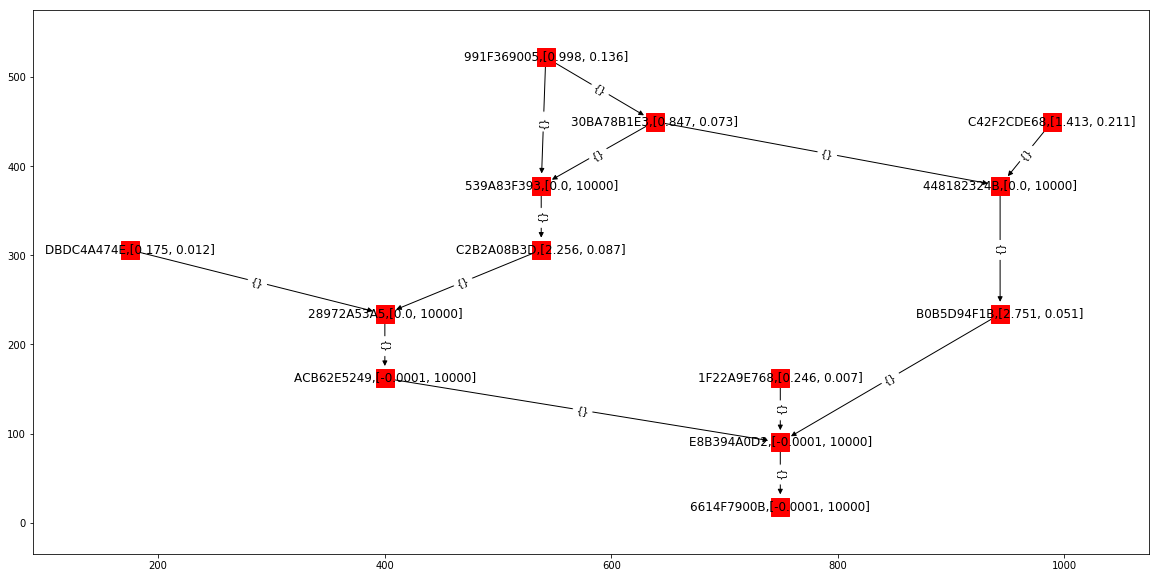

In [13]:
workload_subgraph = workload.compute_execution_subgraph(vertex)
unified_problem = HelixReuse().unify_graph(workload_subgraph, experiment_graph, vertex)
plot_graph(graph=unified_problem, prog='dot')
unified_problem.nodes(data=True)

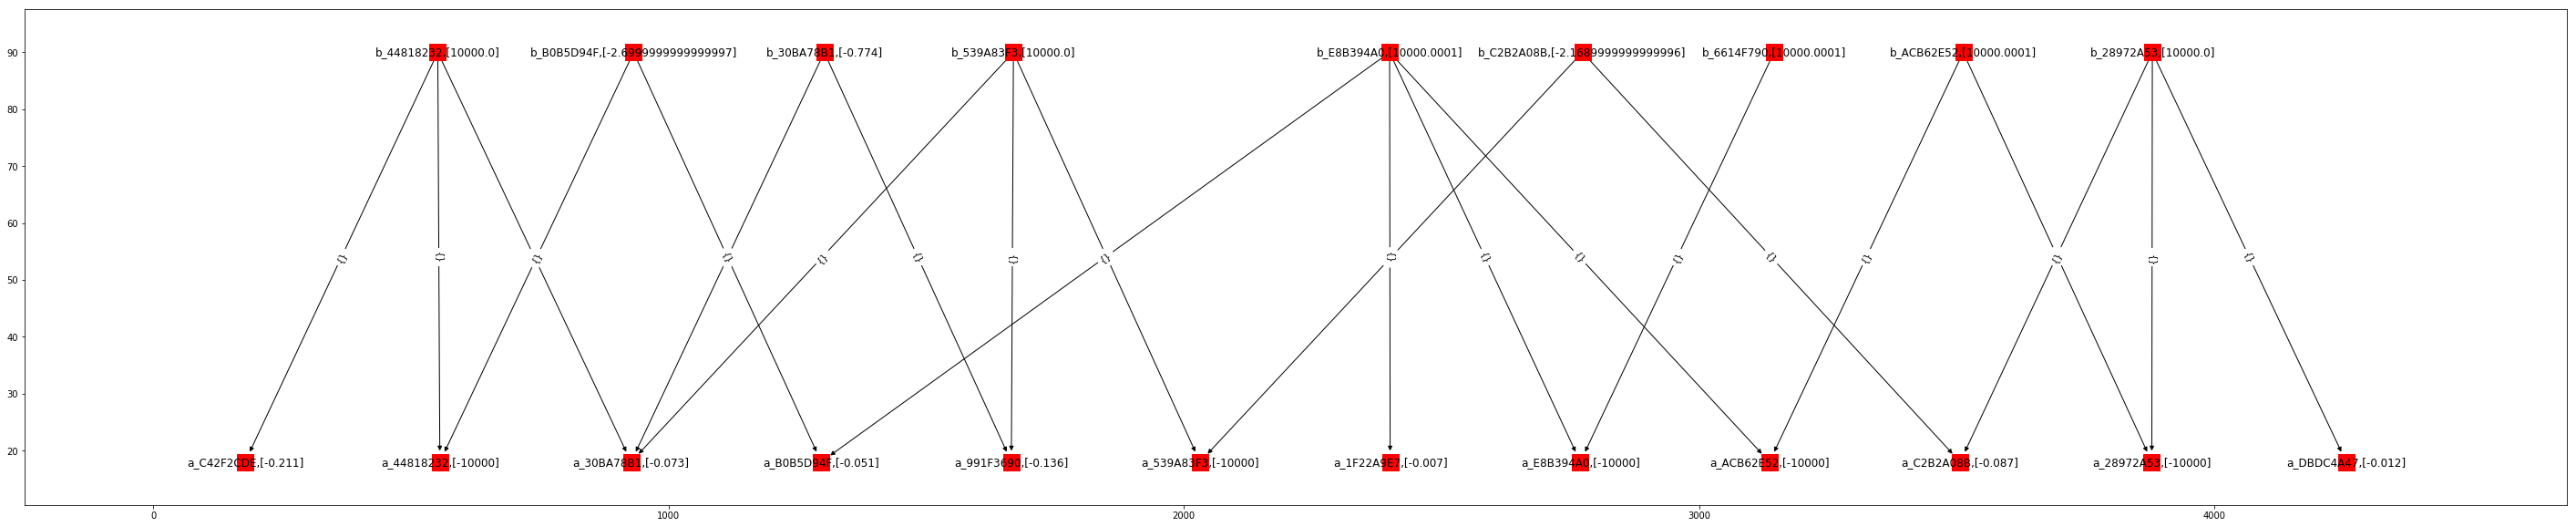

In [14]:
psp_graph = HelixReuse().workload_graph_to_psp(unified_problem)
plot_graph(figsize=(50,10), graph=psp_graph, prog='dot')

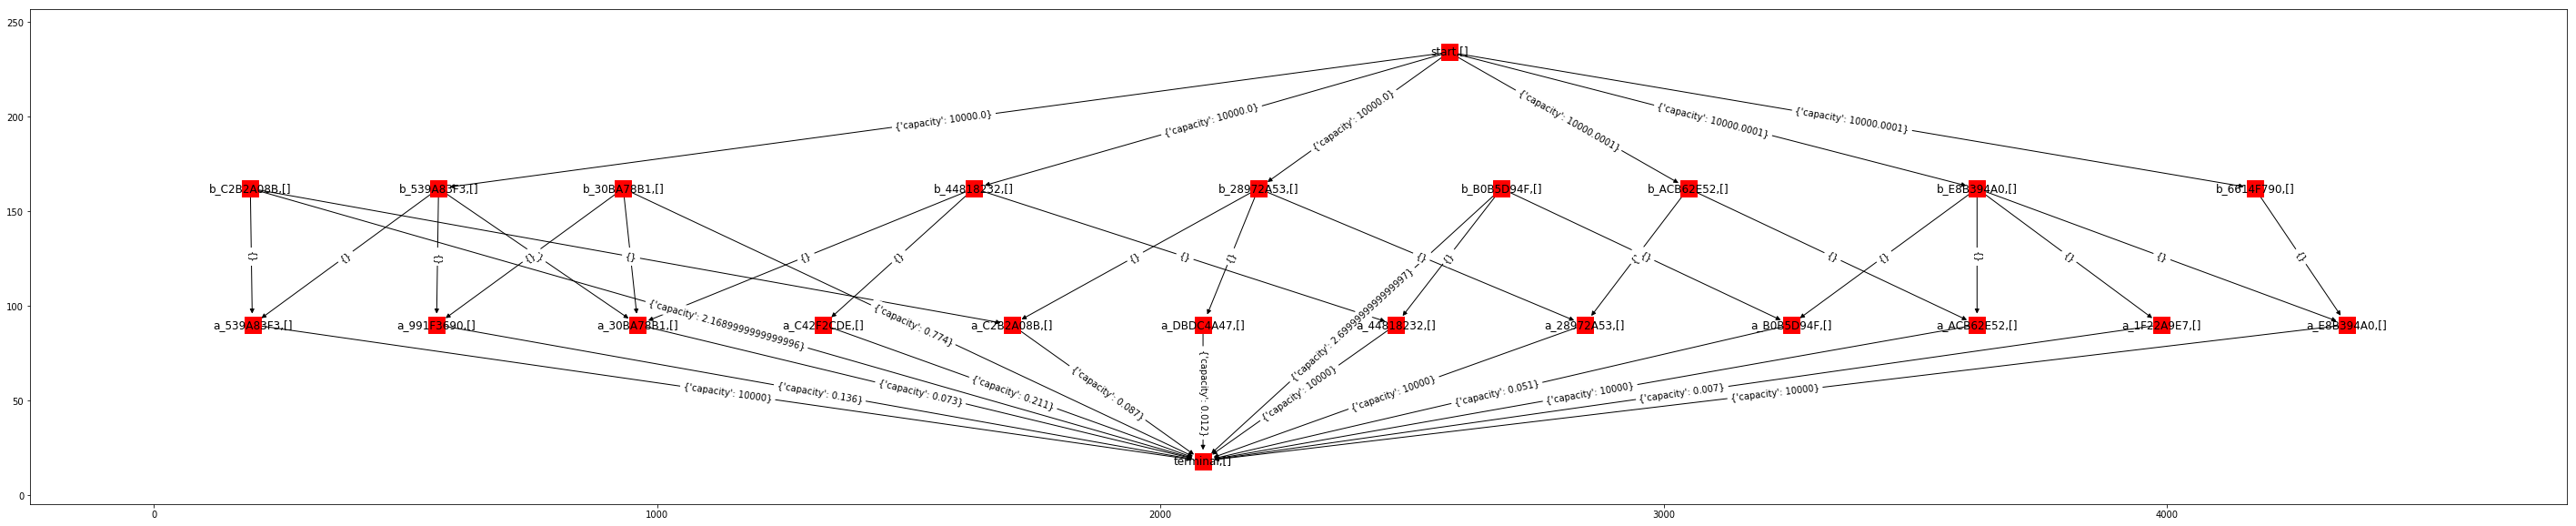

In [15]:
max_flow_graph = HelixReuse().psp_to_max_flow(psp_graph)
plot_graph(figsize=(50,10),graph=max_flow_graph)

In [16]:
mat_helix, compute_helix,_ = helix_reuse(terminal_vertex, executor.execution_environment)
mat_linear, compute_linear,_ = linear_reuse(terminal_vertex, executor.execution_environment)
print(mat_helix,mat_linear)
assert mat_helix == mat_linear
assert compute_linear == compute_helix

executor.cleanup()

(set(['B0B5D94F1B43F18EF00C461EC8EEDFAF', 'DBDC4A474E8B084B17D4A95D82CBA082', '1F22A9E7687B4B9E5ED728910FC93F1A', 'C2B2A08B3D0EFA08C2A06B7187FF500B']), set(['C2B2A08B3D0EFA08C2A06B7187FF500B', 'DBDC4A474E8B084B17D4A95D82CBA082', '1F22A9E7687B4B9E5ED728910FC93F1A', 'B0B5D94F1B43F18EF00C461EC8EEDFAF']))


True